In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import pandas as pd
import numpy as np
import xarray as xr
import intake

import config
import oco2mip_ff
import util

In [12]:
use_dask = True

if use_dask:
    cluster, client = util.get_ClusterClient(memory='64GB')
    cluster.scale(12) #adapt(minimum_jobs=2, maximum_jobs=5)
    cluster

/glade/work/mclong/miniconda3/envs/sno/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45568 instead
  f"Port {expected} is already in use.\n"


In [13]:
version = 'v2020.1'
yr1, yr2 = 2000, 2020

date_range = pd.date_range(start=f'{yr1:04d}-01-01', end=f'{yr2:04d}-12-31', freq='1M')
date_range

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31'],
              dtype='datetime64[ns]', length=252, freq='M')

In [14]:
if use_dask:
    ds_list_list = client.map(oco2mip_ff.retrieve_datasets, date_range, version=version)
    ds_list_list = client.gather(ds_list_list)
else:
    ds_list_list = []
    for date in date_range:
        ds_list_list.append(oco2mip_ff.retrieve_datasets(date, version=version))
        
ds_list = [ds for ds_list in ds_list_list for ds in ds_list]

ds = xr.concat([ds[['SFCO2_FF', 'time_bnds']] for ds in ds_list], dim='time', compat='override', coords='minimal').squeeze()
ds['area'] = ds_list[0].area
for v in ds.variables:
    ds[v].encoding = ds_list[0][v].encoding

ds

distributed.scheduler - ERROR - Couldn't gather keys {"('open_dataset-ab3211ca0ba37b863ddfa5802df7aeeeitime-88acc184c2736509bc499c68e84e0194', 0, 0)": []} state: [None] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('open_dataset-ab3211ca0ba37b863ddfa5802df7aeeeitime-88acc184c2736509bc499c68e84e0194', 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('open_dataset-3215e748f710a9c5cd4ec43b5d83ab5ditime-a5b1c02209bf7300c71c94ce56d82cb3', 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('open_dataset-3215e748f710a9c5cd4ec43b5d83ab5ditime-a5b1c02209bf7300c71c94ce56d82cb3', 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('open_dataset-58917c461d82ed1a3a852d118a505714itime-4081697075e0b77165504cb8c69fa00b', 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't 

<xarray.Dataset>
Dimensions:    (time: 7671, lat: 180, lon: 360, d2: 2)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time       (time) object 2000-01-01 12:00:00 ... 2020-12-31 12:00:00
Dimensions without coordinates: d2
Data variables:
    SFCO2_FF   (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    time_bnds  (time, d2) object 2000-01-01 00:00:00 ... 2021-01-01 00:00:00
    area       (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>

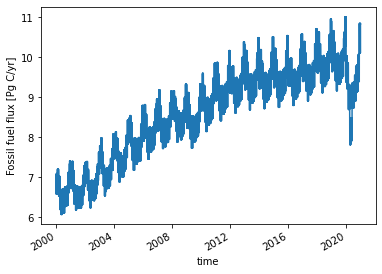

In [24]:
with xr.set_options(keep_attrs=True):
    sfco2_global = ds.SFCO2_FF.weighted(ds.area).sum(['lat', 'lon'])
    sfco2_global *= 12.01e-15 * 86400.0 * 365.0
sfco2_global.attrs['units'] = 'Pg C/yr'
sfco2_global['time'] = [np.datetime64(f'{d.year}-{d.month:02d}-{d.day:02d}') for d in sfco2_global.time.values]
sfco2_global.plot()

In [25]:
%%time
file_out = f"{config.flux_product_dir}/SFCO2_FF.OCO2-MIP-FF.{version}.{yr1:04d}0101-{yr2:04d}1231.nc"
ds.attrs['description'] = f'daily integral of Fossil Fuel CO2 Emissions for the OCO2 Model Intercomparison Project (MIP)'
ds.attrs['source'] = 'https://zenodo.org/record/4776925'
ds.attrs['authors'] = 'Basu, Sourish;  Nassar, Ray'
ds.attrs['note'] = 'daily integration and compilation by Matt Long (NCAR)'
util.to_netcdf_clean(ds, file_out, format='NETCDF4')

------------------------------
Writing /glade/work/mclong/sno-analysis/flux-products/SFCO2_FF.OCO2-MIP-FF.v2020.1.20000101-20201231.nc
netcdf SFCO2_FF.OCO2-MIP-FF.v2020.1.20000101-20201231 {
dimensions:
	time = 7671 ;
	lat = 180 ;
	lon = 360 ;
	d2 = 2 ;
variables:
	float SFCO2_FF(time, lat, lon) ;
		SFCO2_FF:_FillValue = 9.96921e+36f ;
		SFCO2_FF:comment = "ODIAC fossil fuel flux convolved with TIMES emission factors" ;
		SFCO2_FF:authors = "ODIAC from Tomohiro Oda (tom.oda@nasa.gov), TIMES from Ray Nassar (ray.nassar@canada.ca), convolved by Sourish Basu (sourish.basu@noaa.gov)" ;
		SFCO2_FF:long_name = "Fossil fuel flux" ;
		SFCO2_FF:units = "mol/m^2/s" ;
		SFCO2_FF:cell_methods = "time: sum" ;
	double time_bnds(time, d2) ;
		time_bnds:long_name = "Bounds for time integration" ;
	double lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
	double lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "Latitude" ;
	double time(time) ;
		time:bounds = "time_b

In [26]:
curator = util.curate_flux_products()
curator.add_source(
        key=f"SFCO2_FF.OCO2-MIP.{version}",
        urlpath=file_out,
        description='daily integral of Fossil Fuel CO₂ Emissions for the OCO2 Model Intercomparison Project (MIP)',
    )

In [27]:
if use_dask:
    del client
    del cluster